<a href="https://colab.research.google.com/github/asjvarma/asjvarma/blob/main/11590786_Jayanth_Varma_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


************* Fold : 1 **************
Epoch: 1, Training Loss: 0.0012, Acc 65.4922, Validation Loss: 0.0098, Acc 67.4203, Testing Loss: 0.0069, Acc 67.6659,
Epoch: 2, Training Loss: 0.0020, Acc 65.5759, Validation Loss: 0.0072, Acc 65.1951, Testing Loss: 0.0072, Acc 68.9023,
Epoch: 3, Training Loss: 0.0017, Acc 67.0802, Validation Loss: 0.0054, Acc 67.4280, Testing Loss: 0.0072, Acc 67.7922,
Epoch: 4, Training Loss: 0.0021, Acc 68.3731, Validation Loss: 0.0069, Acc 67.4825, Testing Loss: 0.0071, Acc 66.0418,
Epoch: 5, Training Loss: 0.0013, Acc 65.8988, Validation Loss: 0.0068, Acc 66.4495, Testing Loss: 0.0072, Acc 68.6005,
Epoch: 6, Training Loss: 0.0017, Acc 68.5275, Validation Loss: 0.0069, Acc 64.5865, Testing Loss: 0.0070, Acc 68.2975,
Epoch: 7, Training Loss: 0.0012, Acc 63.9200, Validation Loss: 0.0082, Acc 69.2294, Testing Loss: 0.0072, Acc 69.2342,
Epoch: 8, Training Loss: 0.0017, Acc 67.3404, Validation Loss: 0.0083, Acc 65.3316, Testing Loss: 0.0069, Acc 67.9059,
Epoch: 9,

Text(0.5, 60.0, 'y_pred')

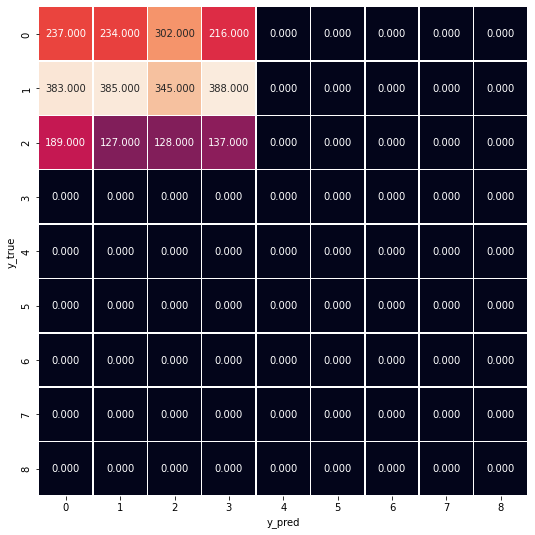

In [ ]:
# -*- coding: utf-8 -*-
"""twitter_sentiment_pytorch

#importing modules/packages
import os
import gensim
import pandas as pd
import numpy as np 
import torch 
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import tqdm
import string
import nltk

from torch import nn
from torch.utils.data import random_split, SubsetRandomSampler, ConcatDataset
from gensim.models import Word2Vec
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns 

from string import punctuation
from nltk.tokenize import TweetTokenizer

punctuation = list(punctuation)

import warnings
warnings.filterwarnings(action = 'ignore')

#reading data files
train_text = pd.read_csv("/content/sample_data/dataset/train_text.txt", sep="\r\n", names=["tweets"])
train_labels = pd.read_csv("/content/sample_data/dataset/train_labels.txt", sep="\r\n", names=["labels"])

val_text = pd.read_csv("/content/sample_data/dataset/val_text.txt", sep="\r\n", names=["tweets"])
val_labels = pd.read_csv("/content/sample_data/dataset/val_labels.txt", sep="\r\n", names=["labels"])

test_text = pd.read_csv("/content/sample_data/dataset/test_text.txt", sep="\r\n", names=["tweets"])
test_labels = pd.read_csv("/content/sample_data/dataset/test_labels.txt", sep="\r\n", names=["labels"])

# define function to clean tweets
def clean_tweets(tweet):
    # tweet to lowercase
    tweet = tweet.lower()
    # instantiate tokenizer class
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    #tweet tokenize
    tokens = tokenizer.tokenize(tweet)
    clean_tweet = [token for token in tokens if token not in punctuation]

    return clean_tweet

#clean tweets texts
train_text['clean_tweets'] = train_text['tweets'].apply(lambda x: (clean_tweets(x)))
test_text['clean_tweets'] = test_text['tweets'].apply(lambda x: (clean_tweets(x)))
val_text['clean_tweets'] = val_text['tweets'].apply(lambda x: (clean_tweets(x)))

#creating Word2Vec model
X = train_text['clean_tweets']
w2v_model = Word2Vec(X, size=50, window=5, min_count=1)

vocabs = {}
for id, vocab in enumerate(w2v_model.wv.vocab):
    vocabs[vocab] = id + 2

#longest sentence length
length = train_text['clean_tweets'].apply(lambda x: ([len(x)])).max()[0]

#replacing tweet words with their respective ids from vocabs list
def check_word_fill(words):
    ids = []
    for word in words:
        if word in vocabs:
            ids.append(vocabs[word])
        else:
            ids.append(1)
    if len(ids) < length:
      for j in range(length-len(ids)):
        ids.append(0)
    
    return ids

#train
train_text['words_ids'] = train_text['clean_tweets'].apply(lambda x:(check_word_fill(x)))
train_text['to_tensors'] = train_text['words_ids'].apply(lambda x:torch.LongTensor(x))
train_text_stack = torch.stack(list(train_text['to_tensors'].values))

#test
test_text['words_ids'] = test_text['clean_tweets'].apply(lambda x:(check_word_fill(x)))
test_text['to_tensors'] = test_text['words_ids'].apply(lambda x:torch.LongTensor(x))
test_text_stack = torch.stack(list(test_text['to_tensors'].values))

#val
val_text['words_ids'] = val_text['clean_tweets'].apply(lambda x:(check_word_fill(x)))
val_text['to_tensors'] = val_text['words_ids'].apply(lambda x:torch.LongTensor(x))
val_text_stack = torch.stack(list(val_text['to_tensors'].values))

#get vocabulary vectors
vec = w2v_model.wv.vectors
min_vec = w2v_model.wv.vectors.min()
max_vec = w2v_model.wv.vectors.max()
vec_len = 50

pre_trained_emb = pd.np.insert(vec, 0, pd.np.random.uniform(min_vec, max_vec, vec_len), axis=0)  
pre_trained_emb = torch.FloatTensor(pd.np.insert(pre_trained_emb, 0, pd.np.zeros(vec_len),axis=0))

# Model
class NetworkModel(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super().__init__()
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding = nn.EmbeddingBag.from_pretrained(pre_trained_emb)
        self.linear1 = nn.Linear(embedding_dim, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, 1)
    
    def forward(self, seq):
        input = self.embedding(seq)
        pred1 = self.linear1(input)
        pred1 = self.relu(pred1)
        pred2 = self.linear2(pred1).squeeze()
        
        return pred2

#model instantiation
model = NetworkModel(embedding_dim = 50, hidden_size = 25)

#loss function
criterion = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-3)
# model

#datasets 
training_dataset = data.TensorDataset(train_text_stack, torch.FloatTensor(train_labels['labels'].values))
valid_dataset = data.TensorDataset(val_text_stack, torch.FloatTensor(val_labels['labels'].values))
testing_dataset = data.TensorDataset(test_text_stack, torch.FloatTensor(test_labels['labels'].values))

#concat training, testing & valid
dataset = ConcatDataset([training_dataset, valid_dataset])

test_dataloader = data.DataLoader(testing_dataset, batch_size=4)
y_pred = []
y_true = []

epochs = 50
def train_val_test(epochs, model, optimizer, criterion, train_dataloader, valid_dataloader, test_dataloader):

    for epoch in range(epochs):
        #set loss to zero
        train_loss = 0.0
        valid_loss = 0.0
        test_loss = 0.0

        # set acc to zero
        trainrunning_corrects = 0
        train_corrects = 0
        vrunning_corrects = 0
        val_corrects = 0
        testrunning_corrects = 0
        test_corrects = 0
        
        #set model for train
        model.train()
        
        for id, batch in enumerate(train_dataloader):
            # [tweets, label]
            target, labels = batch
            
            #optimizer, clear the gradients  
            optimizer.zero_grad()
            
            #Forward Pass
            predict = model(target)
            _, pred = torch.max(predict, 0)
            
            # Find the Loss
            loss = criterion(predict, labels)
            
            # Calculate gradients 
            loss.backward()
            
            # Update Weights
            optimizer.step()

            #accuracy
            trainrunning_corrects += (pred == labels).sum()
            train_corrects += pred
            
            # Calculate Loss
            train_loss = loss.item() * target.size(0)
            
        training_loss = train_loss/len(train_dataloader)
        training_acc = (trainrunning_corrects.double()*100) / train_corrects
        
        #set model for evalution
        model.eval()
        for id, batch in enumerate(valid_dataloader):
            # [tweets, labels]
            target, labels = batch
            
            predict = model(target)
            _, pred = torch.max(predict, 0)

            loss = criterion(predict, labels)

            valid_loss = loss.item() * target.size(0)

            #accuracy
            vrunning_corrects += (pred == labels).sum()
            val_corrects += pred
            

        val_loss = valid_loss/len(valid_dataloader)
        val_acc = (vrunning_corrects.double()*100) / val_corrects

        # testing model
        for id, batch in enumerate(test_dataloader):
            # [tweets, labels]
            target, labels = batch
            
            predict = model(target)
            _, pred = torch.max(predict, 0)
            y_pred.extend(predict)

            loss = criterion(predict, labels)
            y_true.extend(labels)

            test_loss = loss.item() * target.size(0)

            #accuracy
            testrunning_corrects += (pred == labels).sum()
            test_corrects += pred
        
        testing_loss = test_loss/len(test_dataloader)
        testing_acc = (testrunning_corrects.double()*100) / test_corrects

        print('Epoch: {}, Training Loss: {:.4f}, Acc {:.4f}, Validation Loss: {:.4f}, Acc {:.4f}, Testing Loss: {:.4f}, Acc {:.4f},'.\
              format(epoch+1, training_loss, training_acc, val_loss, val_acc, testing_loss, testing_acc))

k = 3
splits = KFold(n_splits = k, shuffle=True, random_state=42)
fold_performance = {}

for fold, (train, val) in enumerate(splits.split(np.arange(len(dataset)))):

    print(f'\n************* Fold : { fold + 1 } **************')

    train_sample = SubsetRandomSampler(train)
    val_sample = SubsetRandomSampler(val)
    
    train_dataloader = data.DataLoader(dataset, batch_size=4, sampler=train_sample)
    val_dataloader = data.DataLoader(dataset, batch_size=4, sampler=val_sample)

    train_val_test(epochs, model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader)

confusion_matrix = torch.zeros(9, 9)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dataloader):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 0)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot = True, fmt = '0.3f', linewidth=0.5, square = True, cbar = False)
plt.ylabel("y_true")
plt.xlabel("y_pred")